# Resampling over sample data to verify the functions

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from statistics import mean, stdev
from scipy.stats import norm

In [2]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.4.2


In [3]:
# load iris data 
iris = load_iris()
df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


Text(0.5, 0, 'Sepal Width')

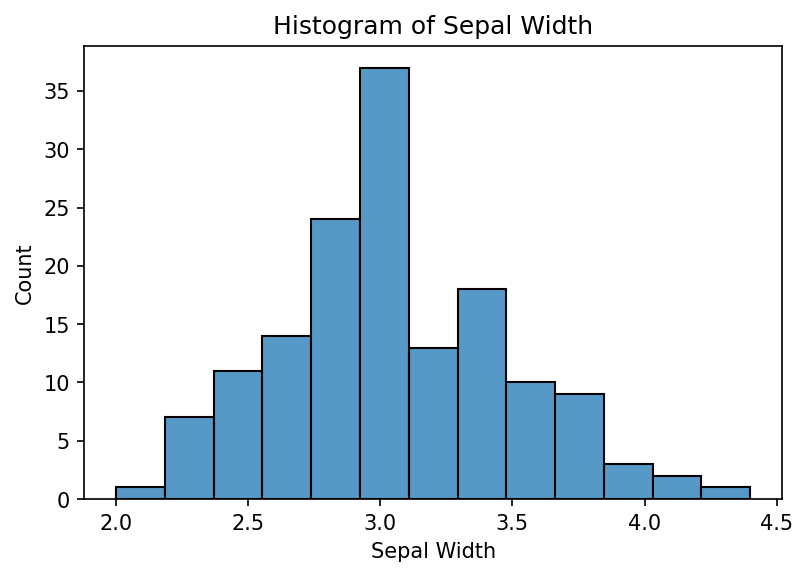

In [4]:
plt.figure(dpi=150)
sns.histplot(df['sepal width (cm)'])
plt.title('Histogram of Sepal Width')
plt.xlabel('Sepal Width')

In [5]:
sepal_width = df['sepal width (cm)']
pop_mean = mean(sepal_width)
print('The mean for sepal width is', pop_mean)

The mean for sepal width is 3.0573333333333332


## From the whole population, we only observe 50 data and we would like to estimate the mean for the whole population from the observed data.

In [6]:
obs_width = np.random.choice(sepal_width, size=50, replace=False)
obs_width

array([3.2, 3.4, 3.2, 3. , 3.5, 3. , 2.8, 3.8, 3. , 2.9, 3. , 3.4, 2.8,
       2.6, 3. , 2.5, 3.8, 3.1, 3.2, 2.8, 3.2, 3.6, 2.8, 3. , 3.2, 3.9,
       4.4, 3. , 2.9, 2.9, 3.5, 3.2, 2.5, 3. , 3.8, 3.4, 2.4, 2.6, 2.8,
       4.2, 2.9, 3.2, 3.4, 2.8, 3. , 3. , 2.6, 2.8, 2.7, 3.4])

In [7]:
def bootstrap(data, bootstrap_size, func):
    '''
    data: data to bootstrap
    bootstrap_size: bootstrap size
    func: parameter to estimate
    '''
    n = len(data)
    param_bt = [0] * bootstrap_size
    
    for i in range(bootstrap_size):
        sample_bt = np.random.choice(data, n, replace=True)
        param_bt[i] = func(sample_bt)
        
    return param_bt

In [8]:
width_mean_bt = bootstrap(obs_width, 10000, mean)

In [20]:
def get_CI_normal(data, confidence, est_param):
    '''
    @data: estimated parameters (e.g. means of 1000 resample data)
    @confidence: width of the interval
    @est_param: value of the estimated parameter of the data that is resampled
    '''
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1) # change degree of freedom
    lower = est_param - qnorm * np.std(data, ddof=1)

    return lower, upper


def get_CI_quantile(data, confidence, est_param=None):
    
    cutoff = (1 - confidence) / 2
    lower = np.quantile(data, cutoff)
    upper = np.quantile(data, 1 - cutoff)

    return lower, upper


def get_CI_biased_corrected_norm(data, confidence, est_param=None):
    param_bar = mean(data)
    est_bias = param_bar - est_param
    est_param -= est_bias
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = est_param + qnorm * np.std(data, ddof=1)
    lower = est_param - qnorm * np.std(data, ddof=1)
    
    return lower, upper

In [10]:
normal = get_CI_normal(width_mean_bt, 0.95, mean(obs_width))

In [11]:
quantile = get_CI_quantile(width_mean_bt, 0.95, mean(obs_width))

In [12]:
biased = get_CI_biased_corrected_norm(width_mean_bt, 0.95, mean(obs_width))

In [13]:
print('The population mean is', pop_mean, '\n')
print('The observed mean is', mean(obs_width), '\n')
print('Normal CI', normal, '\n')
print('Normal CI', quantile, '\n')
print('Normal CI', biased, '\n')

The population mean is 3.0573333333333332 

The observed mean is 3.122 

Normal CI (3.0048529555409913, 3.2391470444590085) 

Normal CI (3.008, 3.2439999999999998) 

Normal CI (3.004951555540991, 3.2392456444590083) 



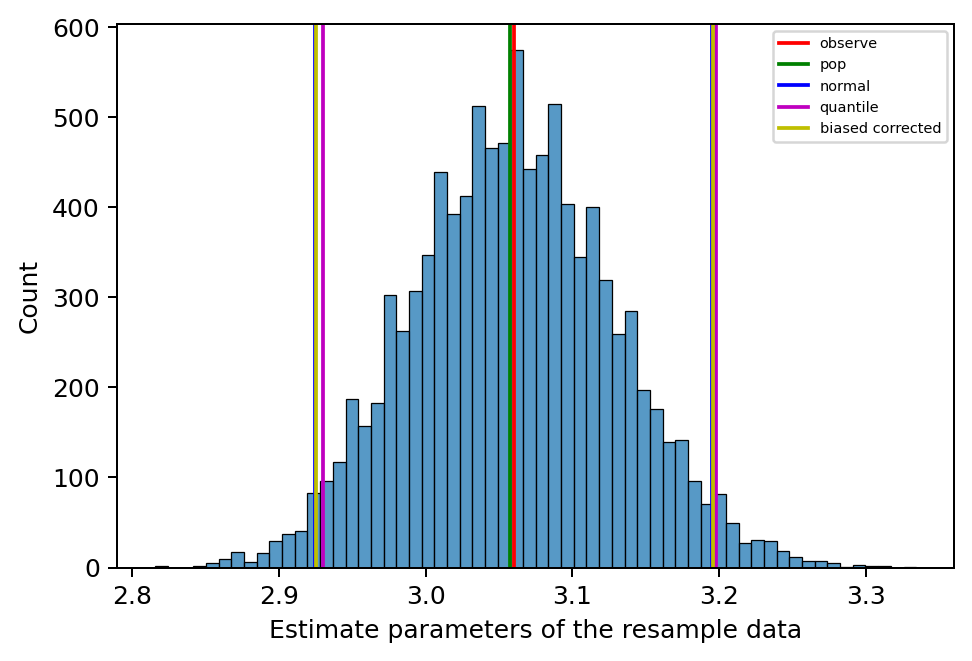

In [14]:
fig = plt.figure(dpi=180)
sns.histplot(width_mean_bt)
plt.axvline(x=mean(obs_width), color = 'r', label = 'observe')
plt.axvline(x=pop_mean, color = 'g', label = 'pop')
plt.axvline(x=normal[0], color = 'b', label = 'normal')
plt.axvline(x=normal[1], color = 'b')
plt.axvline(x=quantile[0], color = 'm', label = 'quantile')
plt.axvline(x=quantile[1], color = 'm')
plt.axvline(x=biased[0], color = 'y', label = 'biased corrected')
plt.axvline(x=biased[1], color = 'y')
plt.legend(loc='best', fontsize = 'xx-small')
plt.xlabel('Estimate parameters of the resample data')
plt.show()

In [14]:
# pseudo values method 
def jackknife(x, func):
    n = len(x)
    pse = []
    idx = np.arange(n)
    
    for i in range(n):
        one_out = x[idx != i]
        pse.append(n * func(x) - (n - 1) * func(one_out))
        
    return pse
        

def jackknife_block(x, func, nfold):
    kf = KFold(n_splits=nfold)
    pse = []
    
    for index,_ in kf.split(x):
        block = x[index]
        pse.append(nfold * func(x) - (nfold - 1) * func(block))
        
    return np.array(pse)


def jk_get_CI(x, confidence):
    
    qnorm = abs(norm.ppf((1 - confidence) / 2))

    upper = mean(x) + qnorm * np.std(x, ddof=1) / sqrt(len(x)) # change degree of freedom
    lower = mean(x) - qnorm * np.std(x, ddof=1) / sqrt(len(x))

    return lower, upper

In [16]:
jk = jackknife(obs_width, mean)
jk_CI = jk_get_CI(jk, 0.95)

In [17]:
jk_block = jackknife_block(obs_width, mean, nfold=5)
jk_block_CI = jk_get_CI(jk_block, 0.95)

In [18]:
print('The population mean is', pop_mean, '\n')
print('The observed mean is', mean(obs_width), '\n')
print('Normal CI by Jackknife is', jk_CI, '\n')
print('Normal CI by Jackknife Block is', jk_block_CI, '\n')

The population mean is 3.0573333333333332 

The observed mean is 3.06 

Normal CI by Jackknife is (2.9226026703150536, 3.1973973296849474) 

Normal CI by Jackknife Block is (2.8310111074692172, 3.2889888925307846) 



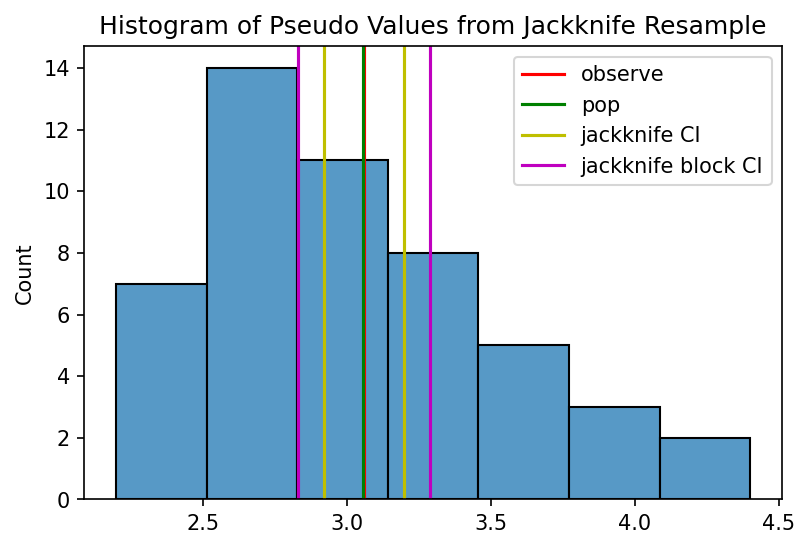

In [19]:
fig2 = plt.figure(dpi=150)
sns.histplot(jk)
plt.axvline(x=mean(obs_width), color = 'r', label = 'observe')
plt.axvline(x=pop_mean, color = 'g', label = 'pop')
plt.axvline(x=jk_CI[0], color = 'y', label = 'jackknife CI')
plt.axvline(x=jk_CI[1], color = 'y')
plt.axvline(x=jk_block_CI[0], color = 'm', label = 'jackknife block CI')
plt.axvline(x=jk_block_CI[1], color = 'm')
plt.legend(loc=0)
plt.title('Histogram of Pseudo Values from Jackknife Resample')
plt.show()

### Now we try to replicate the resampling many times to obtain the coverage rate value to observe whether it is close to the confidence. We will randomly 'observe' different sample sizes (1/10, 1/5, 1/3, etc.) of data from the population data and then apply resampling methods over the observed data. We also try to vary the sample sizes because we want to see how sample sizes will affect the confidence interval and the coverage rate. 

In [43]:
def bt_replicate(data, sample_size, replicate_size, est_function, CI_function, confidence, 
                 bootstrap_size, plot=False):
    '''
    @data: interested to resample 
    @sample_size: a list of sample size 
    @replicate_size: times we want to do the experiment
    @est_function: function to use to estimate the interested parameter (mean, median, variance, etc.)
    @CI_function: methods of getting the confidence interval
    @confidence: confidence rate (90%, 95%, ...)
    @bootstrap_size: number of times we want to do the bootstrap
    
    Return the coverage rate of each replication
    '''
    coverage = []
    
    if plot:
        fig, ax = plt.subplots(figsize=(20, 8))
        
    color = ['r', 'g', 'b']
    pop_value = est_function(data)
    
    for i in range(len(sample_size)):
        
        # randomly select 10 observed data of size[i]
        rd_data = [np.random.choice(data, sample_size[i], replace=False) for _ in range(replicate_size)]
        
        within = []
    
        for j in range(len(rd_data)):
            observe = rd_data[j]
            
            resample_data = bootstrap(observe, bootstrap_size, est_function)
            lower, upper = CI_function(resample_data, confidence, est_function(observe))
            
            if plot:
                ax.plot((j + 0.1 * i, j + 0.1 * i), (lower, upper), 'o-', color = color[i])
            
            if lower < pop_value < upper:
                within.append(1)
            else:
                within.append(0)
        
        coverage.append(within)
        
    if plot:
        ax.axhline(pop_value, xmin = 0, xmax = 10, color = 'y')
        ax.set(ylabel = 'Estimated parameter')
        ax.legend(labels = ['20', '40', '60'], labelcolor = color)
        ax.set_title('Confidence Intervals')

        plt.show()
    
    return coverage

## Now, we will randonly select 10 different observed data of size 20, 40, 60 to evaluate the coverage rate. 

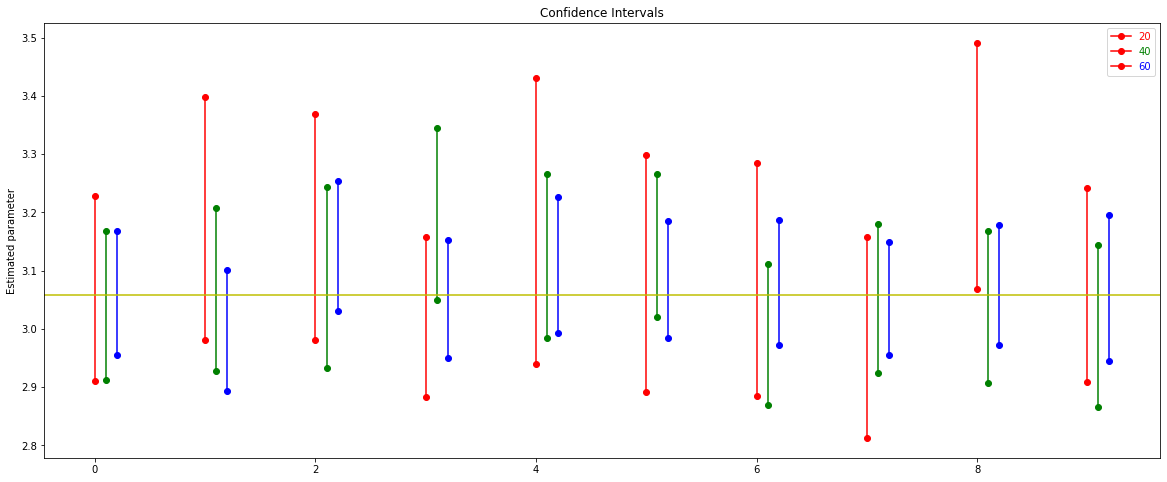

In [34]:
obs_size = [20, 40, 60]
bt_coverage = bt_replicate(sepal_width, obs_size, 10, mean, get_CI_normal, 0.95, 1000, plot=True)

In [44]:
def jk_replicate(data, sample_size, replicate_size, est_function, confidence, nfold=None, plot=False):
    '''
    @data: interested to resample 
    @sample_size: a list of sample size 
    @replicate_size: times we want to do the experiment
    @est_function: function to use to estimate the interested parameter (mean, median, variance, etc.)
    @confidence: confidence rate (90%, 95%, ...)
    @nfold: number of block if we try to use jackknife block methods
    @plot: whether or not plot the confidence interval
    '''
    
    coverage = []
    
    if plot: 
        fig, ax = plt.subplots(figsize=(20, 8))
        
    color = ['r', 'g', 'b']
    pop_value = est_function(data)
    
    for i in range(len(sample_size)):
        
        rd_data = [np.random.choice(data, sample_size[i], replace=False) for _ in range(replicate_size)]
        
        within = []
    
        for j in range(len(rd_data)):
            observe = rd_data[j]
            
            if nfold:
                pseudo_values = jackknife_block(observe, est_function, nfold)
            else:
                pseudo_values = jackknife(observe, est_function)

            lower, upper = jk_get_CI(pseudo_values, confidence)

            if plot: 
                ax.plot((j + 0.1 * i, j + 0.1 * i), (lower, upper), 'o-', color = color[i])
            
            if lower < pop_value < upper:
                within.append(1)
            else:
                within.append(0)
        
        coverage.append(within)
        
    if plot:
        ax.axhline(pop_value, xmin = 0, xmax = 10, color = 'y')
        ax.set(ylabel = 'Estimated parameter')
        ax.legend(labels = ['20', '40', '60'], labelcolor = color)
        ax.set_title('Confidence Intervals')
        plt.show()
    
    return coverage

In [32]:
jk_coverage = jk_replicate(sepal_width, obs_size, 10, mean, 0.95)

In [36]:
jk_coverage

[[1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]]

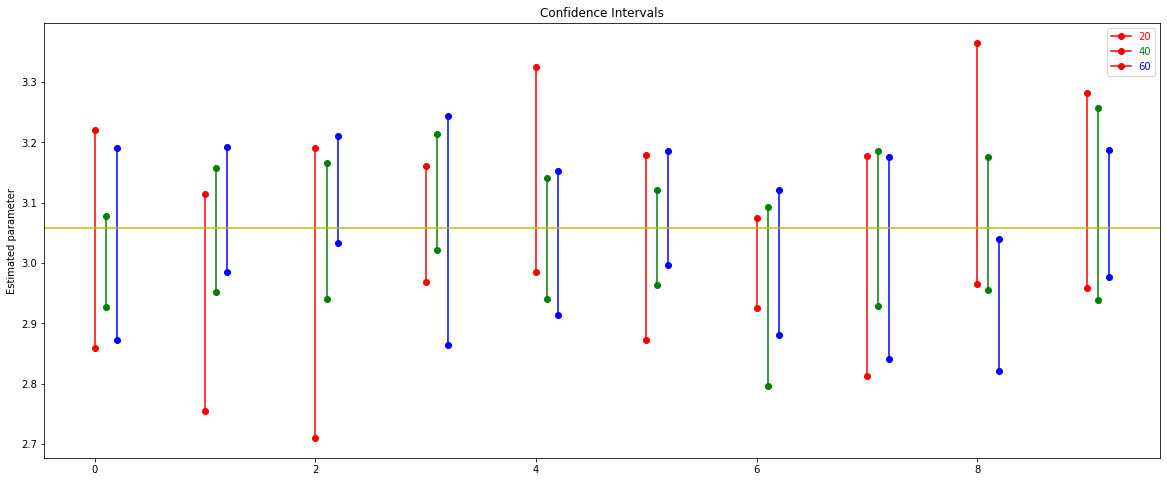

In [37]:
jk_block_coverage = jk_replicate(sepal_width, obs_size, pop_mean, mean, 0.95, 5)

In [38]:
jk_block_coverage

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]

## Now, we try to run more Replicates of Resampling.

In [55]:
obs_size = [20, 40, 60]
bt_coverage_large = bt_replicate(sepal_width, obs_size, 100, mean, get_CI_normal, 0.95, 1000)
jk_coverage_large = jk_replicate(sepal_width, obs_size, 100, mean, 0.95)
jk_block_coverage_large = jk_replicate(sepal_width, obs_size, 100, mean, 0.95, 5)

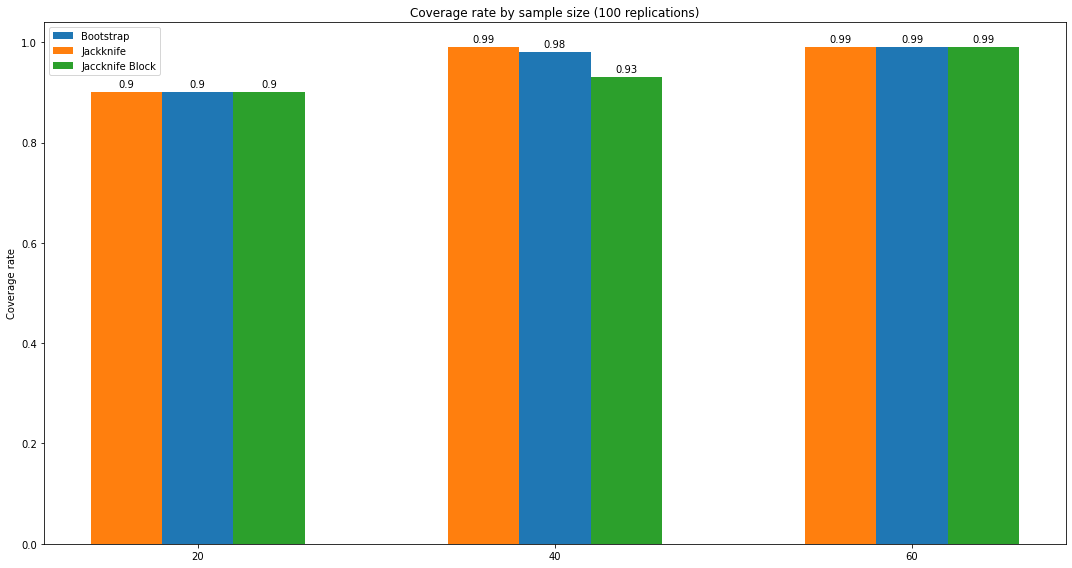

In [58]:
labels = obs_size
bt_rate = [mean(coverage) for coverage in bt_coverage_large]
jk_rate = [mean(coverage) for coverage in jk_coverage_large]
jk_block_rate = [mean(coverage) for coverage in jk_block_coverage_large]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))
bt_rect = ax.bar(x, bt_rate, width, label = 'Bootstrap')
jk_rect = ax.bar(x - width, jk_rate, width, label='Jackknife')
jk_block_rect = ax.bar(x + width, jk_block_rate, width, label='Jaccknife Block')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coverage rate')
ax.set_title('Coverage rate by sample size (100 replications)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(bt_rect, padding=3)
ax.bar_label(jk_rect, padding=3)
ax.bar_label(jk_block_rect, padding=3)

fig.tight_layout()

plt.show()

### Try the same methods on a larger dataset

In [68]:
from sklearn.datasets import load_breast_cancer

In [62]:
bc_data = load_breast_cancer()
bc_df = pd.DataFrame(bc_data['data'], columns=bc_data['feature_names'])
bc_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### We are interested in the mean radius of the cancer.

Text(0.5, 0, 'radius')

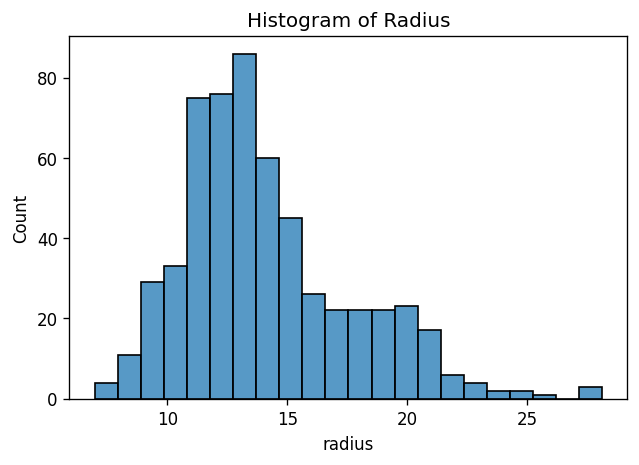

In [65]:
plt.figure(dpi=120)
sns.histplot(bc_df['mean radius'])
plt.title('Histogram of Radius')
plt.xlabel('radius')

In [66]:
radius = bc_df['mean radius']
print('The mean for radius is', mean(radius))

The mean for radius is 14.127291739894552


In [69]:
n = len(radius)
obs_size = [50, 150, 250, 350, 450]
bt_coverage_large = bt_replicate(radius, obs_size, 100, mean, get_CI_normal, 0.95, 1000)
jk_coverage_large = jk_replicate(radius, obs_size, 100, mean, 0.95)
jk_block_coverage_large = jk_replicate(radius, obs_size, 100, mean, 0.95, 5)

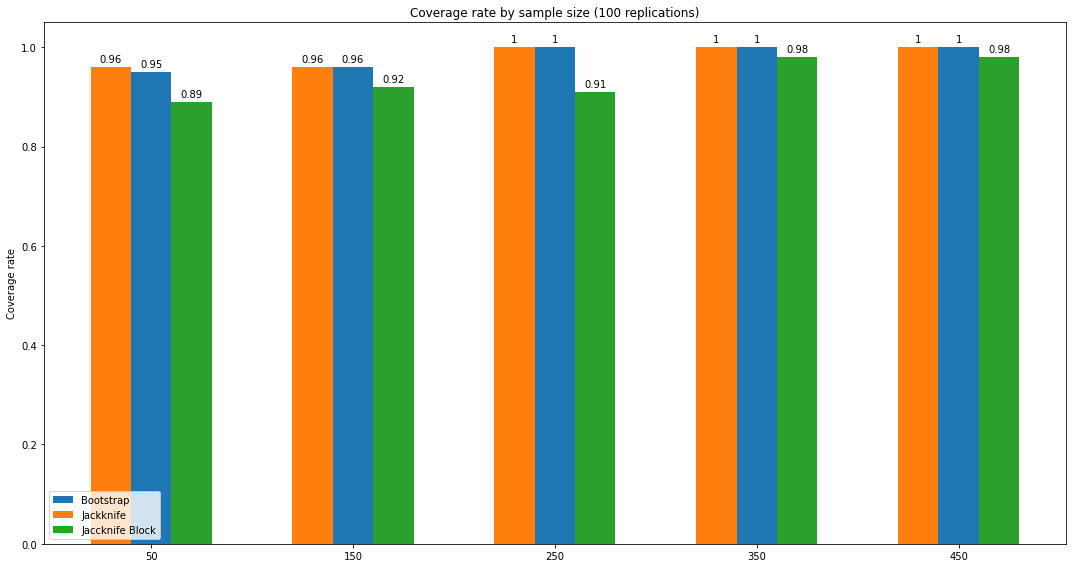

In [72]:
labels = obs_size
bt_rate = [mean(coverage) for coverage in bt_coverage_large]
jk_rate = [mean(coverage) for coverage in jk_coverage_large]
jk_block_rate = [mean(coverage) for coverage in jk_block_coverage_large]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))
bt_rect = ax.bar(x, bt_rate, width, label = 'Bootstrap')
jk_rect = ax.bar(x - width, jk_rate, width, label='Jackknife')
jk_block_rect = ax.bar(x + width, jk_block_rate, width, label='Jaccknife Block')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Coverage rate')
ax.set_title('Coverage rate by sample size (100 replications)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower left')

ax.bar_label(bt_rect, padding=3)
ax.bar_label(jk_rect, padding=3)
ax.bar_label(jk_block_rect, padding=3)

fig.tight_layout()

plt.show()

#### To Be Continued

In [130]:
bt_coverage_normal = bt_coverage(obs_width, mean, get_CI_normal, 0.95, pop_mean, 20, 1000)
bt_coverage_quantile = bt_coverage(obs_width, mean, get_CI_quantile, 0.95, pop_mean, 20, 1000)
bt_coverage_biased = bt_coverage(obs_width, mean, get_CI_biased_corrected_norm, 0.95, pop_mean, 20, 1000)
jk_coverage_rate = jk_coverage(obs_width, mean, 0.95, pop_mean, 20)
jk_block_coverage = jk_coverage(obs_width, mean, 0.95, pop_mean, 20, nfold=5)

In [131]:
coverage_df = {'pop_width': [pop_mean] * 5,
               'obs_width': [mean(obs_width)] * 5,
               'resample method': ['bootstrap', 'bootstrap', 'bootstrap', 'jackknife', 'jackknife block'],
               'CI method': ['noraml', 'quantile', 'biased corrected', 'pseudo normal', 'pseudo normal'],
               'confidence': ['95%'] * 5, 
               'resample means': [bt_coverage_normal, bt_coverage_quantile, bt_coverage_biased, jk_coverage_rate, jk_block_coverage],
               'rate': [mean(bt_coverage_normal), mean(bt_coverage_quantile), 
                        mean(bt_coverage_biased), mean(jk_coverage_rate), mean(jk_block_coverage)]}

coverage_df = pd.DataFrame(coverage_df)

In [132]:
coverage_df.style

,pop_width,obs_width,resample method,CI method,confidence,resample means,rate
0,3.057333,3.110000,bootstrap,noraml,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
1,3.057333,3.110000,bootstrap,quantile,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
2,3.057333,3.110000,bootstrap,biased corrected,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
3,3.057333,3.110000,jackknife,pseudo normal,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
4,3.057333,3.110000,jackknife block,pseudo normal,95%,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
